<a href="https://colab.research.google.com/github/MartynaPlomecka/chi23/blob/main/martyna_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading dependencies

In [39]:
import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install sktime
!{sys.executable} -m pip install catboost
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install seaborn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import os
import glob
from pathlib import Path
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import sktime
import scipy
from sktime.pipeline import make_pipeline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.panel.segment import IntervalSegmenter
from sktime.transformations.series.exponent import ExponentTransformer
from sktime.classification.interval_based import DrCIF
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.datatypes import check_raise
from google.colab import drive
import ast
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")



# Data loading

In [41]:
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/ETRA-Data/data/outfiles'  
files = Path(path).glob('*.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# load the template matched precomputed timepoints:
labels_switches = pd.read_csv(r'/content/drive/MyDrive/ETRA-Data/template_matched.csv')
# Seperate sbj and trial:
labels_switches['sbj'], labels_switches['trial'], _, _ = labels_switches['name'].str.split('_').str
# labels_switches.drop(columns=['name'],inplace=True)


<ipython-input-42-962561028342>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  labels_switches['sbj'], labels_switches['trial'], _, _ = labels_switches['name'].str.split('_').str


In [43]:
labels_switches


,name,09_fps,10_fps,11_fps,gaze_length,most similar vid length,shortest distance,is_video_shorter,switches_to_video,frames_total,switches_back,sbj,trial
0,ZE14_man_2022-08-10_13h14.05.398.avi,174.000000,156.6,142.363636,146.44,142.36,4.08,yes,[413],1565,[428],ZE14,man
1,ZE14_woman_2022-08-10_13h17.54.923.avi,226.666667,204.0,185.454545,201.69,204.00,2.31,no,[],2039,[],ZE14,woman
2,ZE16_man_2022-07-27_10h45.25.687.avi,166.111111,149.5,135.909091,152.89,149.50,3.39,yes,[325],1494,[345],ZE16,man
3,ZE16_woman_2022-07-27_10h49.35.870.avi,176.444444,158.8,144.363636,176.68,176.44,0.24,yes,[],1587,[],ZE16,woman
4,ZE18_man_2022-07-26_11h42.09.353.avi,129.666667,116.7,106.090909,129.35,129.67,0.32,no,[55],1166,[113],ZE18,man
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,ZN60_man_2022-07-07_20h57.53.698.avi,164.444444,148.0,134.545455,127.65,134.55,6.90,no,"[158, 374, 607, 1145]",1479,"[298, 557, 822, 1350]",ZN60,man
89,ZN7_man_2022-06-24_15h56.45.248.avi,364.555556,328.1,298.272727,294.87,298.27,3.40,no,"[793, 1286, 1867, 2736]",3280,"[1136, 1386, 2186, 2872]",ZN7,man
90,ZN7_woman_2022-06-24_16h03.58.687.avi,252.444444,227.2,206.545455,273.36,252.44,20.92,yes,[],2271,[],ZN7,woman
91,ZN8_man_2022-07-08_14h09.50.629.avi,458.444444,412.6,375.090909,406.25,412.60,6.35,no,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",4125,"[234, 255, 904, 1232, 1497, 1771, 2322, 2743, ...",ZN8,man


In [44]:
labels_scores = pd.read_csv('/content/drive/MyDrive/ETRA-Data/scores_binary.csv')
labels_scores.head()

labels_scores_man = labels_scores.copy()
labels_scores_woman = labels_scores.copy()

labels_scores_man["file"] = labels_scores_man["sbj"] + "_man"
labels_scores_man["score"] = labels_scores_man["man"]
labels_scores_man.drop(columns=['man', "woman", "total"],inplace=True)
labels_scores_woman["file"] = labels_scores_woman["sbj"] + "_woman"
labels_scores_woman["score"] = labels_scores_woman["woman"]
labels_scores_woman.drop(columns=['man', "woman", "total"],inplace=True)

labels_scores = pd.concat([labels_scores_man, labels_scores_woman])

In [45]:
labels_scores

,sbj,score,pass_fail,file
0,ZE14,3,1,ZE14_man
1,ZE16,4,1,ZE16_man
2,ZE18,2,0,ZE18_man
3,ZE49,2,0,ZE49_man
4,ZE59,4,1,ZE59_man
...,...,...,...,...
46,ZN53,4,1,ZN53_woman
47,ZN54,2,0,ZN54_woman
48,ZN55,3,0,ZN55_woman
49,ZN59,2,0,ZN59_woman


# Data Preparation

In [46]:
# Seperate sbj and task:
labels_scores['sbj'], labels_scores['task'] = labels_scores['file'].str.split('_', 1).str
print(labels_scores["task"].unique())
labels_scores['task'] = labels_scores['task'].replace(['man','woman'], ['1','2'])
labels_scores['task'] = labels_scores['task'].astype(int)
labels_scores

['man' 'woman']


<ipython-input-46-ef50997518ff>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  labels_scores['sbj'], labels_scores['task'] = labels_scores['file'].str.split('_', 1).str


,sbj,score,pass_fail,file,task
0,ZE14,3,1,ZE14_man,1
1,ZE16,4,1,ZE16_man,1
2,ZE18,2,0,ZE18_man,1
3,ZE49,2,0,ZE49_man,1
4,ZE59,4,1,ZE59_man,1
...,...,...,...,...,...
46,ZN53,4,1,ZN53_woman,2
47,ZN54,2,0,ZN54_woman,2
48,ZN55,3,0,ZN55_woman,2
49,ZN59,2,0,ZN59_woman,2


In [47]:
my_lists = [ast.literal_eval(labels_switches["switches_to_video"][i]) for i in range(len(labels_switches.index))]
total = sum(len(l) for l in my_lists)
print(f"We have in total in all the datasets: {total} switches")

We have in total in all the datasets: 416 switches


In [48]:
labels_switches["switches_listformat"] = my_lists
labels_switches = pd.DataFrame(labels_switches)
labels_switches

,name,09_fps,10_fps,11_fps,gaze_length,most similar vid length,shortest distance,is_video_shorter,switches_to_video,frames_total,switches_back,sbj,trial,switches_listformat
0,ZE14_man_2022-08-10_13h14.05.398.avi,174.000000,156.6,142.363636,146.44,142.36,4.08,yes,[413],1565,[428],ZE14,man,[413]
1,ZE14_woman_2022-08-10_13h17.54.923.avi,226.666667,204.0,185.454545,201.69,204.00,2.31,no,[],2039,[],ZE14,woman,[]
2,ZE16_man_2022-07-27_10h45.25.687.avi,166.111111,149.5,135.909091,152.89,149.50,3.39,yes,[325],1494,[345],ZE16,man,[325]
3,ZE16_woman_2022-07-27_10h49.35.870.avi,176.444444,158.8,144.363636,176.68,176.44,0.24,yes,[],1587,[],ZE16,woman,[]
4,ZE18_man_2022-07-26_11h42.09.353.avi,129.666667,116.7,106.090909,129.35,129.67,0.32,no,[55],1166,[113],ZE18,man,[55]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,ZN60_man_2022-07-07_20h57.53.698.avi,164.444444,148.0,134.545455,127.65,134.55,6.90,no,"[158, 374, 607, 1145]",1479,"[298, 557, 822, 1350]",ZN60,man,"[158, 374, 607, 1145]"
89,ZN7_man_2022-06-24_15h56.45.248.avi,364.555556,328.1,298.272727,294.87,298.27,3.40,no,"[793, 1286, 1867, 2736]",3280,"[1136, 1386, 2186, 2872]",ZN7,man,"[793, 1286, 1867, 2736]"
90,ZN7_woman_2022-06-24_16h03.58.687.avi,252.444444,227.2,206.545455,273.36,252.44,20.92,yes,[],2271,[],ZN7,woman,[]
91,ZN8_man_2022-07-08_14h09.50.629.avi,458.444444,412.6,375.090909,406.25,412.60,6.35,no,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",4125,"[234, 255, 904, 1232, 1497, 1771, 2322, 2743, ...",ZN8,man,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2..."


In [49]:
#amount of switches
labels_switches['number'] = labels_switches.switches_listformat.map(len)
labels_switches

,name,09_fps,10_fps,11_fps,gaze_length,most similar vid length,shortest distance,is_video_shorter,switches_to_video,frames_total,switches_back,sbj,trial,switches_listformat,number
0,ZE14_man_2022-08-10_13h14.05.398.avi,174.000000,156.6,142.363636,146.44,142.36,4.08,yes,[413],1565,[428],ZE14,man,[413],1
1,ZE14_woman_2022-08-10_13h17.54.923.avi,226.666667,204.0,185.454545,201.69,204.00,2.31,no,[],2039,[],ZE14,woman,[],0
2,ZE16_man_2022-07-27_10h45.25.687.avi,166.111111,149.5,135.909091,152.89,149.50,3.39,yes,[325],1494,[345],ZE16,man,[325],1
3,ZE16_woman_2022-07-27_10h49.35.870.avi,176.444444,158.8,144.363636,176.68,176.44,0.24,yes,[],1587,[],ZE16,woman,[],0
4,ZE18_man_2022-07-26_11h42.09.353.avi,129.666667,116.7,106.090909,129.35,129.67,0.32,no,[55],1166,[113],ZE18,man,[55],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,ZN60_man_2022-07-07_20h57.53.698.avi,164.444444,148.0,134.545455,127.65,134.55,6.90,no,"[158, 374, 607, 1145]",1479,"[298, 557, 822, 1350]",ZN60,man,"[158, 374, 607, 1145]",4
89,ZN7_man_2022-06-24_15h56.45.248.avi,364.555556,328.1,298.272727,294.87,298.27,3.40,no,"[793, 1286, 1867, 2736]",3280,"[1136, 1386, 2186, 2872]",ZN7,man,"[793, 1286, 1867, 2736]",4
90,ZN7_woman_2022-06-24_16h03.58.687.avi,252.444444,227.2,206.545455,273.36,252.44,20.92,yes,[],2271,[],ZN7,woman,[],0
91,ZN8_man_2022-07-08_14h09.50.629.avi,458.444444,412.6,375.090909,406.25,412.60,6.35,no,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",4125,"[234, 255, 904, 1232, 1497, 1771, 2322, 2743, ...",ZN8,man,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",12


In [50]:
labels_switches['task'] = labels_switches ['trial'].replace(['man', 'Man','woman', 'Woman'], ['1','1','2','2'])
labels_switches ['task'] = labels_switches['task'].astype(int)
labels_switches  = pd.DataFrame(labels_switches )

Merge Willie's scores with the switches data to get the full table with all the info needed for stats:

In [51]:
df2 = pd.merge(labels_switches , labels_scores, on=['task','sbj'])
df2

,name,09_fps,10_fps,11_fps,gaze_length,most similar vid length,shortest distance,is_video_shorter,switches_to_video,frames_total,switches_back,sbj,trial,switches_listformat,number,task,score,pass_fail,file
0,ZE14_man_2022-08-10_13h14.05.398.avi,174.000000,156.6,142.363636,146.44,142.36,4.08,yes,[413],1565,[428],ZE14,man,[413],1,1,3,1,ZE14_man
1,ZE14_woman_2022-08-10_13h17.54.923.avi,226.666667,204.0,185.454545,201.69,204.00,2.31,no,[],2039,[],ZE14,woman,[],0,2,4,1,ZE14_woman
2,ZE16_man_2022-07-27_10h45.25.687.avi,166.111111,149.5,135.909091,152.89,149.50,3.39,yes,[325],1494,[345],ZE16,man,[325],1,1,4,1,ZE16_man
3,ZE16_woman_2022-07-27_10h49.35.870.avi,176.444444,158.8,144.363636,176.68,176.44,0.24,yes,[],1587,[],ZE16,woman,[],0,2,4,1,ZE16_woman
4,ZE18_man_2022-07-26_11h42.09.353.avi,129.666667,116.7,106.090909,129.35,129.67,0.32,no,[55],1166,[113],ZE18,man,[55],1,1,2,0,ZE18_man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,ZN60_man_2022-07-07_20h57.53.698.avi,164.444444,148.0,134.545455,127.65,134.55,6.90,no,"[158, 374, 607, 1145]",1479,"[298, 557, 822, 1350]",ZN60,man,"[158, 374, 607, 1145]",4,1,4,1,ZN60_man
85,ZN7_man_2022-06-24_15h56.45.248.avi,364.555556,328.1,298.272727,294.87,298.27,3.40,no,"[793, 1286, 1867, 2736]",3280,"[1136, 1386, 2186, 2872]",ZN7,man,"[793, 1286, 1867, 2736]",4,1,2,0,ZN7_man
86,ZN7_woman_2022-06-24_16h03.58.687.avi,252.444444,227.2,206.545455,273.36,252.44,20.92,yes,[],2271,[],ZN7,woman,[],0,2,2,0,ZN7_woman
87,ZN8_man_2022-07-08_14h09.50.629.avi,458.444444,412.6,375.090909,406.25,412.60,6.35,no,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",4125,"[234, 255, 904, 1232, 1497, 1771, 2322, 2743, ...",ZN8,man,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",12,1,2,0,ZN8_man


In [52]:
df2.drop(['name', '09_fps', '10_fps','11_fps','switches_to_video','most similar vid length','shortest distance', 'is_video_shorter','frames_total','switches_back', 'file' ], axis=1, inplace=True)


In [53]:
df2

,gaze_length,sbj,trial,switches_listformat,number,task,score,pass_fail
0,146.44,ZE14,man,[413],1,1,3,1
1,201.69,ZE14,woman,[],0,2,4,1
2,152.89,ZE16,man,[325],1,1,4,1
3,176.68,ZE16,woman,[],0,2,4,1
4,129.35,ZE18,man,[55],1,1,2,0
...,...,...,...,...,...,...,...,...
84,127.65,ZN60,man,"[158, 374, 607, 1145]",4,1,4,1
85,294.87,ZN7,man,"[793, 1286, 1867, 2736]",4,1,2,0
86,273.36,ZN7,woman,[],0,2,2,0
87,406.25,ZN8,man,"[225, 244, 450, 983, 1356, 1600, 2018, 2401, 2...",12,1,2,0


# Stats & plots

In [54]:
print(df2.describe())


       gaze_length     number       task      score  pass_fail
count    89.000000  89.000000  89.000000  89.000000  89.000000
mean    325.931461   4.471910   1.460674   2.674157   0.483146
std     184.334270   3.775188   0.501275   1.135935   0.502547
min      42.380000   0.000000   1.000000   1.000000   0.000000
25%     185.130000   2.000000   1.000000   2.000000   0.000000
50%     294.870000   4.000000   1.000000   2.000000   0.000000
75%     421.990000   7.000000   2.000000   4.000000   1.000000
max     946.180000  17.000000   2.000000   5.000000   1.000000


Correlations:

In [55]:
corr, p_values = scipy.stats.spearmanr(df2['number'], df2['score'])
print(corr, p_values)
#weak but signi relationship between the amount of switches  and the score given by Willie

-0.25199829872847096 0.01720380496340631


In [56]:
corr, p_values = scipy.stats.spearmanr(df2['gaze_length'], df2['score'])
print(corr, p_values)
#weak but signi relationship between the lenght of the task and the score given by Willie

-0.28207365289680414 0.00740470022547654


In [57]:
corr, p_values = scipy.stats.spearmanr(df2['gaze_length'], df2['number'])
print(corr, p_values)

#number of switches strongly correlated with the lenght of the task but thats nothing insightfull xD

0.685200964641206 1.298862922761628e-13


ANOVA test
(Dependent variable is quantitative and independent variable is qualitative)

In [58]:
#gaze lenght and task (woman, man)

anova_args = tuple(df2.groupby('task')['gaze_length'].apply(list).reset_index()['gaze_length'])
f_statistic, p_value = scipy.stats.f_oneway(*anova_args)
f_statistic, p_value #features do not have a dependence between them

(3.549708053321573, 0.06289571166959569)

In [59]:
#gaze lenght and passing test (fail, pass)
anova_args = tuple(df2.groupby('pass_fail')['gaze_length'].apply(list).reset_index()['gaze_length'])
f_statistic, p_value = scipy.stats.f_oneway(*anova_args)
f_statistic, p_value #features do have a dependence between them.

(6.196010214651999, 0.014707110790035996)

In [60]:
#num of switches and task (woman, man)
anova_args = tuple(df2.groupby('task')['number'].apply(list).reset_index()['number'])
f_statistic, p_value = scipy.stats.f_oneway(*anova_args)
f_statistic, p_value #features do have a dependence between them.

(25.552673667410104, 2.3589069274648053e-06)

In [61]:
#num of switches and passing test (fail, pass)
anova_args = tuple(df2.groupby('pass_fail')['number'].apply(list).reset_index()['number'])
f_statistic, p_value = scipy.stats.f_oneway(*anova_args)
f_statistic, p_value #features do not have a dependence between them

(1.1773938474641783, 0.2808848326456151)

chi-squared test
(Qualitative & Qualitative)

In [62]:
#task(woman, man) and passing test (fail, pass)
chi_square_args = pd.crosstab(df2['pass_fail'], 
                    df2['task']).values

_, p_value, _, _ = scipy.stats.chi2_contingency(chi_square_args)
print(p_value)

1.0


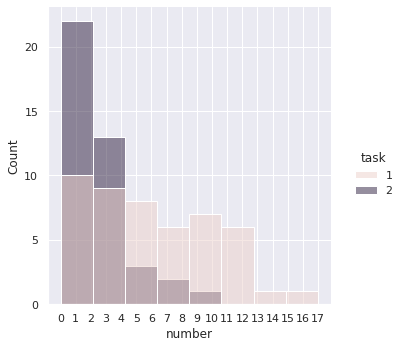

In [63]:
ax = sns.displot(df2, x="number", hue="task")
ax.axes[0][0].xaxis.set_major_locator(ticker.MultipleLocator(1))

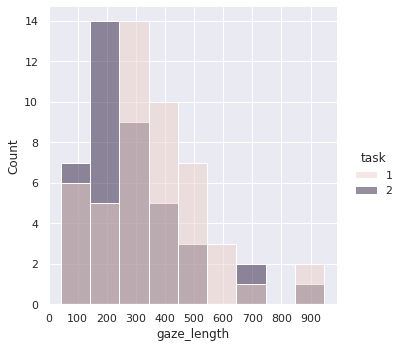

In [64]:
ax = sns.displot(df2, x="gaze_length", hue="task")
ax.axes[0][0].xaxis.set_major_locator(ticker.MultipleLocator(100))

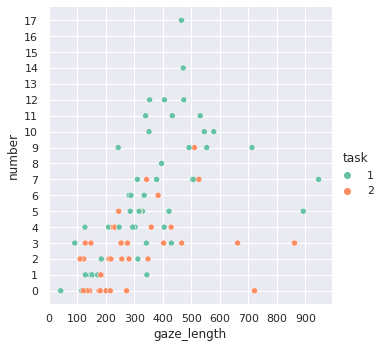

In [65]:
ax = sns.relplot(data = df2.reset_index(), x ="gaze_length", y="number", hue = "task", palette="Set2")
ax.axes[0][0].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.axes[0][0].xaxis.set_major_locator(ticker.MultipleLocator(100))

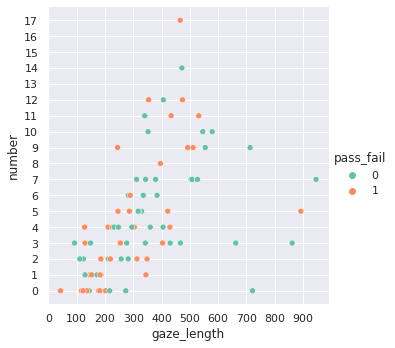

In [66]:
ax = sns.relplot(data = df2.reset_index(), x ="gaze_length", y="number", hue = "pass_fail", palette="Set2")
ax.axes[0][0].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.axes[0][0].xaxis.set_major_locator(ticker.MultipleLocator(100))

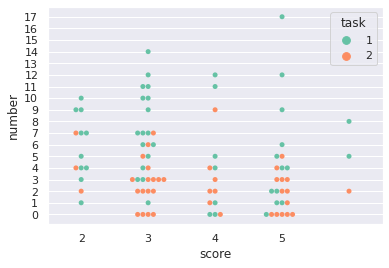

In [67]:
ax = sns.swarmplot(data = df2.reset_index(), y ="number", x="score", hue = "task", palette="Set2")
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))